In [43]:
import datetime,warnings,scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['patch.force_edgecolor']=True
plt.style.use('fivethirtyeight')
mpl.rc('patch',edgecolor='dimgray',linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='last_expr' #show last result
pd.options.display.max_columns=50
%matplotlib inline
warnings.filterwarnings('ignore')

In [44]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [45]:
raw_data = pd.read_csv('air_quality.csv',sep=' ')
raw_data.head()

,No,Profile,Tanggal,Jam,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU,Status,Unnamed: 22
0,1,BANDUNG,2019-05-19,00:04:19,21.35,0.78,6.77,14.06,26.168,409.86,251.202,0.0,0.0,0.0,2.77,0.0,21.4,100.0,0.600,5,9,BAIK,NaN
1,2,BANDUNG,2019-05-19,00:15:01,5.93,0.82,14.87,17.23,53.853,394.79,501.356,0.0,0.0,0.0,11.95,0.0,42.6,200.0,0.000,2,12,BAIK,NaN
2,3,BANDUNG,2019-05-19,00:30:06,6.62,0.63,22.24,2.31,38.304,390.66,753.291,0.0,0.0,0.0,12.71,0.0,63.6,299.2,0.000,2,13,BAIK,NaN
3,4,BANDUNG,2019-05-19,00:49:19,13.29,0.44,19.00,5.32,18.962,401.23,251.043,0.0,0.0,0.0,1.20,0.0,21.3,88.2,0.525,5,6,BAIK,NaN
4,5,BANDUNG,2019-05-19,01:04:19,2.44,0.47,26.74,13.61,35.270,381.67,250.471,0.0,0.0,0.0,3.52,0.0,21.3,97.4,0.975,5,9,BAIK,NaN


In [46]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9231 entries, 0 to 9230
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No           9231 non-null   int64  
 1   Profile      9231 non-null   object 
 2   Tanggal      9231 non-null   object 
 3   Jam          9231 non-null   object 
 4   O3           9231 non-null   float64
 5   CO           9231 non-null   float64
 6   NO2          9231 non-null   float64
 7   SO2          9231 non-null   float64
 8   NO           9231 non-null   float64
 9   CO2          9231 non-null   float64
 10  VOC          9231 non-null   float64
 11  PM1          9231 non-null   float64
 12  PM2.5        9231 non-null   float64
 13  PM4          9231 non-null   float64
 14  PM10         9231 non-null   float64
 15  TSP          9231 non-null   float64
 16  TEMP         9231 non-null   float64
 17  HUM          9231 non-null   float64
 18  WS           9231 non-null   float64
 19  WD    

In [47]:
raw_data.isnull().sum()

No                0
Profile           0
Tanggal           0
Jam               0
O3                0
CO                0
NO2               0
SO2               0
NO                0
CO2               0
VOC               0
PM1               0
PM2.5             0
PM4               0
PM10              0
TSP               0
TEMP              0
HUM               0
WS                0
WD                0
ISPU              0
Status            0
Unnamed: 22    9231
dtype: int64

In [48]:
raw_data.insert(loc=2,column='Datetime',value=np.array([x1 + ' ' + x2[0:2] for x1,x2 in zip(raw_data.Tanggal,raw_data.Jam)],dtype='datetime64'))
raw_data.head()

,No,Profile,Datetime,Tanggal,Jam,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU,Status,Unnamed: 22
0,1,BANDUNG,2019-05-19 00:00:00,2019-05-19,00:04:19,21.35,0.78,6.77,14.06,26.168,409.86,251.202,0.0,0.0,0.0,2.77,0.0,21.4,100.0,0.600,5,9,BAIK,NaN
1,2,BANDUNG,2019-05-19 00:00:00,2019-05-19,00:15:01,5.93,0.82,14.87,17.23,53.853,394.79,501.356,0.0,0.0,0.0,11.95,0.0,42.6,200.0,0.000,2,12,BAIK,NaN
2,3,BANDUNG,2019-05-19 00:00:00,2019-05-19,00:30:06,6.62,0.63,22.24,2.31,38.304,390.66,753.291,0.0,0.0,0.0,12.71,0.0,63.6,299.2,0.000,2,13,BAIK,NaN
3,4,BANDUNG,2019-05-19 00:00:00,2019-05-19,00:49:19,13.29,0.44,19.00,5.32,18.962,401.23,251.043,0.0,0.0,0.0,1.20,0.0,21.3,88.2,0.525,5,6,BAIK,NaN
4,5,BANDUNG,2019-05-19 01:00:00,2019-05-19,01:04:19,2.44,0.47,26.74,13.61,35.270,381.67,250.471,0.0,0.0,0.0,3.52,0.0,21.3,97.4,0.975,5,9,BAIK,NaN


In [49]:
raw_data.columns

Index(['No', 'Profile', 'Datetime', 'Tanggal', 'Jam', 'O3', 'CO', 'NO2', 'SO2',
       'NO', 'CO2', 'VOC', 'PM1', 'PM2.5', 'PM4', 'PM10', 'TSP', 'TEMP', 'HUM',
       'WS', 'WD', 'ISPU', 'Status', 'Unnamed: 22'],
      dtype='object')

In [50]:
df = raw_data.drop(columns=['No','Tanggal','Jam','Unnamed: 22'])
df = df.groupby(['Datetime']).mean().reset_index()
df.head()

,Datetime,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
0,2019-05-19 00:00:00,11.797500,0.667500,15.720,9.7300,34.32175,399.135000,439.22300,0.0,0.0,0.0,7.157500,0.0,37.225000,171.850000,0.28125,3.500000,10.000000
1,2019-05-19 01:00:00,3.816667,0.373333,22.600,20.0900,39.82100,388.536667,250.39400,0.0,0.0,0.0,3.293333,0.0,20.966667,95.033333,0.67500,4.666667,12.666667
2,2019-05-19 02:00:00,6.450000,0.332500,24.130,26.3100,51.29325,396.242500,251.04575,0.0,0.0,0.0,6.487500,0.0,20.150000,97.500000,0.09375,3.750000,16.250000
3,2019-05-19 03:00:00,4.740000,0.180000,25.975,24.3900,43.51850,401.355000,252.24875,0.0,0.0,0.0,4.700000,0.0,19.850000,100.000000,0.07500,5.000000,15.000000
4,2019-05-19 04:00:00,19.692500,0.202500,20.395,18.6225,53.37925,399.335000,694.23975,0.0,0.0,0.0,5.262500,0.0,53.475000,272.500000,0.18750,5.250000,13.250000


In [51]:
df.describe()

,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
count,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000
mean,8.538909,0.233172,16.681910,12.013894,37.086256,394.616480,260.053778,0.309564,0.383692,0.451982,6.157770,0.562012,25.266942,77.634191,24.291226,7.129031,10.097848
std,3.997292,0.388102,5.373487,4.411251,12.521778,4.180224,60.773321,2.286104,2.874126,3.378291,4.149511,4.184787,6.707977,29.743129,51.993683,3.523245,5.049788
min,0.270000,0.010000,2.040000,2.162500,3.128750,380.420000,187.518000,0.000000,0.000000,0.000000,0.885000,0.000000,11.250000,26.866667,0.000000,0.000000,4.250000
25%,5.881667,0.083333,13.010000,9.015000,28.443500,391.830000,247.798333,0.000000,0.000000,0.000000,4.340000,0.000000,21.266667,57.850000,0.237500,4.666667,8.166667
50%,7.813333,0.160000,15.916667,11.730000,39.252250,394.602000,250.926250,0.000000,0.000000,0.000000,5.571667,0.000000,24.100000,77.083333,1.312500,5.833333,9.500000
75%,10.373333,0.296667,19.935000,14.595000,46.015500,397.415000,253.286667,0.000000,0.000000,0.000000,7.090000,0.000000,28.400000,94.066667,5.075000,10.500000,11.000000
max,33.741667,13.950000,99.600000,46.290000,194.554000,408.820000,1240.713500,51.600000,68.700000,79.800000,91.600000,92.900000,124.600000,313.400000,199.200000,15.000000,156.500000


<Figure size 864x288 with 0 Axes>

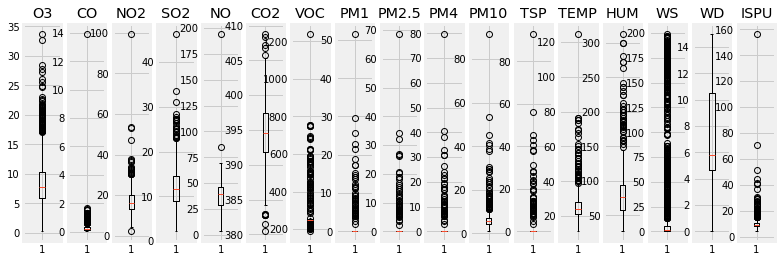

In [52]:
plt.figure(figsize=(12,4))
t = 0
fig,axes = plt.subplots(nrows=1,ncols=len(df.select_dtypes(include='number').columns),figsize=(12,4))
for i in df.select_dtypes(include='number').columns:
    axes[t].set_title(i)
    axes[t].boxplot(df[i])
    t+=1

In [53]:
# calculate quantile
def quantile(i, df):
        Q1 = df[[i]].quantile(0.25)[0]
        Q3 = df[[i]].quantile(0.75)[0]
        IQR = Q3 - Q1
        min = df[[i]].min()[0]
        max = df[[i]].max()[0]
        min_IQR = Q1 - 1.5*IQR
        max_IQR = Q3 + 1.5*IQR

        return Q1,Q3,min,max,min_IQR,max_IQR

In [54]:
#interpolate the outliers with linear method
for i in df.select_dtypes(include='number').columns:
    print('\nAttribute -',i,':')
    Q1, Q3, min, max, min_IQR, max_IQR = quantile(i, df)
    
    if i=='HUM': max_IQR=100
    def convert_nan (x, max_IQR=max_IQR, min_IQR=min_IQR):
        if ((x > max_IQR) | (x < min_IQR)):
            x = np.nan
        else:
            x = x
        return x
    
    df[i] = df[i].map(convert_nan)
    df[i].interpolate(method='linear',inplace=True,limit_direction='both')

    
    if (len(df[df[i].isnull()][i]) == 0):
        print('No outliers exist')

    


Attribute - O3 :
################  Outliers have been interpolated  ################

Attribute - CO :
################  Outliers have been interpolated  ################

Attribute - NO2 :
################  Outliers have been interpolated  ################

Attribute - SO2 :
################  Outliers have been interpolated  ################

Attribute - NO :
################  Outliers have been interpolated  ################

Attribute - CO2 :
################  Outliers have been interpolated  ################

Attribute - VOC :
################  Outliers have been interpolated  ################

Attribute - PM1 :
################  Outliers have been interpolated  ################

Attribute - PM2.5 :
################  Outliers have been interpolated  ################

Attribute - PM4 :
################  Outliers have been interpolated  ################

Attribute - PM10 :
################  Outliers have been interpolated  ################

Attribute - TSP :
################  Outlie

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1737 entries, 0 to 1736
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  1737 non-null   datetime64[ns]
 1   O3        1737 non-null   float64       
 2   CO        1736 non-null   float64       
 3   NO2       1737 non-null   float64       
 4   SO2       1737 non-null   float64       
 5   NO        1737 non-null   float64       
 6   CO2       1737 non-null   float64       
 7   VOC       1736 non-null   float64       
 8   PM1       1737 non-null   float64       
 9   PM2.5     1737 non-null   float64       
 10  PM4       1737 non-null   float64       
 11  PM10      1737 non-null   float64       
 12  TSP       1737 non-null   float64       
 13  TEMP      1737 non-null   float64       
 14  HUM       1736 non-null   float64       
 15  WS        1737 non-null   float64       
 16  WD        1737 non-null   float64       
 17  ISPU      1737

In [28]:
df.head()

,Datetime,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
0,2019-05-19 00:00:00,11.797500,NaN,15.720,9.730000,34.32175,399.135000,NaN,0.0,0.0,0.0,7.157500,0.0,37.225000,NaN,0.28125,3.500000,10.000000
1,2019-05-19 01:00:00,3.816667,0.373333,22.600,20.090000,39.82100,388.536667,250.39400,0.0,0.0,0.0,3.293333,0.0,20.966667,95.033333,0.67500,4.666667,12.666667
2,2019-05-19 02:00:00,6.450000,0.332500,24.130,19.600833,51.29325,396.242500,251.04575,0.0,0.0,0.0,6.487500,0.0,20.150000,97.500000,0.09375,3.750000,13.833333
3,2019-05-19 03:00:00,4.740000,0.180000,25.975,19.111667,43.51850,401.355000,252.24875,0.0,0.0,0.0,4.700000,0.0,19.850000,100.000000,0.07500,5.000000,15.000000
4,2019-05-19 04:00:00,7.030833,0.202500,20.395,18.622500,53.37925,399.335000,252.22100,0.0,0.0,0.0,5.262500,0.0,18.950000,100.000000,0.18750,5.250000,13.250000


# Temperature Prediction

array([[<AxesSubplot:title={'center':'TEMP'}>,
        <AxesSubplot:title={'center':'log_TEMP'}>]], dtype=object)

<Figure size 864x360 with 0 Axes>

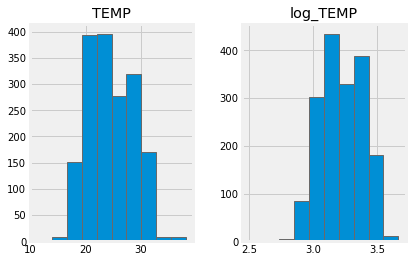

In [15]:
dist_df = pd.DataFrame({'TEMP': df.TEMP.values,'log_TEMP':np.log1p(df.TEMP.values)})
plt.figure(figsize=(12,5))
dist_df.hist()

In [72]:
train_size = int(len(dataset)*0.75)
test_size = len(dataset) - train_size
train,test = dataset[0:train_size-1],dataset[train_size:len(dataset)]
print(len(train),len(test))

6922 2308


In [74]:
def create_dataset(dataset, look_back=1):
    X,Y = [],[]
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back)]
        X.append(a)
        Y.append(dataset[i+look_back])
    return np.array(X),np.array(Y)

In [75]:
look_back=1
X_train, Y_train = create_dataset(train,look_back)
X_test, Y_test = create_dataset(test,look_back)

In [79]:
X_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))

In [81]:
model = Sequential()
model.add(LSTM(4,input_shape=(1,look_back)))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,Y_train,epochs=500,batch_size=32,verbose=2)

Epoch 1/500
217/217 - 2s - loss: nan - 2s/epoch - 10ms/step
Epoch 2/500
217/217 - 0s - loss: nan - 332ms/epoch - 2ms/step
Epoch 3/500
217/217 - 0s - loss: nan - 362ms/epoch - 2ms/step
Epoch 4/500
217/217 - 0s - loss: nan - 333ms/epoch - 2ms/step
Epoch 5/500
217/217 - 0s - loss: nan - 357ms/epoch - 2ms/step
Epoch 6/500
217/217 - 0s - loss: nan - 339ms/epoch - 2ms/step
Epoch 7/500
217/217 - 0s - loss: nan - 346ms/epoch - 2ms/step
Epoch 8/500
217/217 - 0s - loss: nan - 330ms/epoch - 2ms/step
Epoch 9/500
217/217 - 0s - loss: nan - 369ms/epoch - 2ms/step
Epoch 10/500
217/217 - 0s - loss: nan - 331ms/epoch - 2ms/step
Epoch 11/500
217/217 - 0s - loss: nan - 340ms/epoch - 2ms/step
Epoch 12/500
217/217 - 0s - loss: nan - 354ms/epoch - 2ms/step
Epoch 13/500
217/217 - 0s - loss: nan - 331ms/epoch - 2ms/step
Epoch 14/500
217/217 - 0s - loss: nan - 359ms/epoch - 2ms/step
Epoch 15/500
217/217 - 0s - loss: nan - 322ms/epoch - 1ms/step
Epoch 16/500
217/217 - 0s - loss: nan - 328ms/epoch - 2ms/step
Epo